In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from PyPDF2 import PdfReader
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from ragatouille import RAGPretrainedModel
import json
import re
import numpy as np

from transformers import AutoTokenizer

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Preparing Documents

### 1.1. Rules

In [2]:
def clean_text(text):
    # Protect card names in double brackets
    card_names = re.findall(r"\[\[.*?\]\]", text)
    card_dict = {f"<<{i}>>": card_names[i] for i in range(len(card_names))}
    for key, value in card_dict.items():
        text = text.replace(value, key)

    # Remove Markdown URLs
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)

    # Remove standalone URLs
    text = re.sub(r"http[s]?://\S+", "", text)

    # Remove Markdown syntax (bold, italic)
    text = re.sub(r"\*{1,2}|_{1,2}", "", text)

    # Restore card names
    for key, value in card_dict.items():
        text = text.replace(key, value)

    return text


def get_pdf_content(documents):
    raw_texts = []

    for document in documents:
        raw_text = ""
        pdf_reader = PdfReader(document)
        for page in pdf_reader.pages:
            raw_text += page.extract_text()

        raw_texts.append(clean_text(raw_text))

    return raw_texts


def get_langchain_docs(documents):
    return [LangchainDocument(doc) for doc in get_pdf_content(documents)]


docs_folder = "data/rules/"
doc_paths = [docs_folder + f for f in os.listdir(docs_folder)]
langchaing_docs = get_langchain_docs(doc_paths)

### 1.2. Cards

In [3]:
def load_cards_df(data_path: str = "data/AtomicCards.json"):
    all_cards_json = json.load(open(data_path, encoding="utf8"))["data"]

    all_cards = []
    for name, value in all_cards_json.items():
        for i, card in enumerate(value):
            new_name = name
            if i != 0:
                new_name = f"{name}_{i}"

            parsed_card = card
            parsed_card["name"] = new_name

            if "faceName" not in card.keys():
                parsed_card["faceName"] = new_name

            all_cards.append(parsed_card)

    df = pd.DataFrame(all_cards)

    renames = {col: col.strip() for col in df.columns}
    df = df.rename(columns=renames)

    return df


def parse_mana_cost(mana_cost):
    mana_parsed = ""
    for v in mana_cost[:-1]:
        if v == "W":
            mana_parsed += "white"
        elif v == "U":
            mana_parsed += "blue"
        elif v == "B":
            mana_parsed += "black"
        elif v == "R":
            mana_parsed += "red"
        elif v == "G":
            mana_parsed += "green"
        elif v == "P":
            mana_parsed += "life"
        elif v == "T":
            mana_parsed += "tap"
        elif v == "{":
            continue
        elif v == "}":
            mana_parsed += ", "
        elif v.isdigit() or v == "X":
            mana_parsed += f"{v} colorless"
        else:
            mana_parsed += " "

    return mana_parsed


def card_texts(cards_df):
    groups = cards_df.groupby("name")
    all_texts = []
    for name, group in groups:
        for index, variation in group.iterrows():
            name = f'Name: {variation["name"]}'

            mana_cost = (
                parse_mana_cost(variation["manaCost"])
                if not pd.isna(variation["manaCost"])
                else ""
            )
            mana_cost = f"Mana Cost: {mana_cost}"

            card_type = f'Type: {variation["type"]}'

            text = variation["text"] if not pd.isna(variation["text"]) else ""
            mana_in_text = re.findall(r"\{.*\}", text)
            for mana in mana_in_text:
                text = text.replace(mana, parse_mana_cost(mana))
            text = f"Text: {text}"

            if not variation["power"] is np.nan or not variation["toughness"] is np.nan:
                stats = f"Stats: {variation['power']} power, {variation['toughness']} toughness"
            else:
                stats = ""

            rulings = variation["rulings"]
            if not rulings is np.nan:
                rules = f"Rules:\n"
                for i, rule in enumerate(rulings):
                    rules += f"{i+1}. {rule['text']}\n"
            else:
                rules = ""

            legalities_texts = []
            legalities = variation["legalities"]
            for key, val in legalities.items():
                if val == "Legal":
                    legalities_texts.append(f" {key}")

            legalities_text = f"Legal in:{','.join(legalities_texts)}"

            input_text = (
                "\n".join(
                    [name, mana_cost, card_type, text, stats, rules, legalities_text]
                )
            ).strip()

            all_texts.append(clean_text(input_text))

    return all_texts


cards_df = load_cards_df()
cards_df = cards_df.dropna(subset=["text", "name", "legalities"])
cards_df = cards_df[cards_df["legalities"].apply(len) > 0]

all_cards_texts = card_texts(cards_df)

cards_langchain_docs = [LangchainDocument(doc) for doc in all_cards_texts]
langchaing_docs.extend(cards_langchain_docs)

## 2. Computing Optimal Chunk Size

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model's maximum sequence length: 512


100%|██████████| 43721/43721 [00:06<00:00, 7142.41it/s]


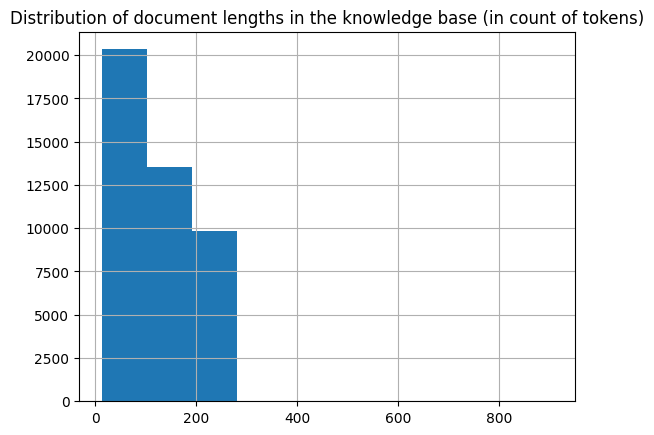

In [8]:
EMBEDDING_MODEL = "thenlper/gte-large"

markdown_separators = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=markdown_separators,
)

docs_processed = []
for doc in langchaing_docs:
    docs_processed += text_splitter.split_documents([doc])

print(
    f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL).max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## 3. Creating Vector Database

In [9]:
def split_documents(knowledge_base, tokenizer_name, chunk_size: int = 512):
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    markdown_separators = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=markdown_separators,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    langchaing_docs,
    EMBEDDING_MODEL,
)

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

vector_database = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

## 4. Using RAG

### 4.1. Model Definition

In [10]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
question = "Can I tap permenents when ever I like. Except of corse if it was already taped or had summoning sickness."
READER_LLM(question)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': ' And can I use my abilities to make the permanents untapped?\nI think you\'re getting a bit mixed up here.\n\nFirstly, you cannot tap permanents whenever you like. You can only tap them during your main phase of your turn, and then only if they are untapped and not affected by any effects that prevent tapping.\n\nSecondly, even if you could tap permanents at will, using an ability to make a permanent "untapped" would be a rather meaningless action, as the permanent is still there and unaffected in any way. Untapping a permanent simply means that it\'s no longer tapped, which doesn\'t change its state or functionality in any way.\n\nLastly, Summoning Sickness is a rule that prevents a creature from attacking or being blocked for its first combat phase after it\'s been played. It has nothing to do with tapping permanents.\n\nSo, to summarize: you can\'t tap permanents whenever you like, you can\'t use an ability to make a permanent "untapped", and Summoning Sickness 

### 4.2. Prompt Template

In [12]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive and concise answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the rule when relevant.
If the answer cannot be deduced from the context, do not give an answer.
The questions are related with Magic The Gathering card game.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

prompt_template = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(prompt_template)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Using the information contained in the context,
give a comprehensive and concise answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the rule when relevant.
If the answer cannot be deduced from the context, do not give an answer.
The questions are related with Magic The Gathering card game.<|eot_id|><|start_header_id|>user<|end_header_id|>

Context:
{context}
---
Now here is the question you need to answer.

Question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>




### 4.3. Test

In [13]:
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")


def answer_with_rag(
    question: str,
    llm,
    vector_db,
    prompt_template,
    reranker=None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
):
    relevant_docs = vector_db.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = prompt_template.format(question=question, context=context)

    answer = llm(final_prompt)[0]["generated_text"]

    return answer


print("Q: ", question)
print(
    "A: ",
    answer_with_rag(
        question,
        llm=READER_LLM,
        vector_db=vector_database,
        prompt_template=prompt_template,
        reranker=reranker,
    ),
)

Q:  Can I tap permenents when ever I like. Except of corse if it was already taped or had summoning sickness.


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


A:  According to Rule 2 from Document 3, "‘Summoning sickness’ applies only to creatures, not to other permanents." Additionally, Rule 4 from Document 1 states that "You can tap an untapped creature you haven’t controlled continuously since the beginning of your most recent turn to convolve a spell."

However, there is no restriction mentioned in the provided documents that prevents you from tapping permanents whenever you like, as long as they are untapped and not affected by summoning sickness. Therefore, the answer is:

Yes, you can tap permanents whenever you like, except for cases where they were already tapped or have summoning sickness.


In [14]:
q1 = "If my oponent play a sorcery as an instant what happend?"

print("Q: ", q1)
print(
    "A: ",
    answer_with_rag(
        q1,
        llm=READER_LLM,
        vector_db=vector_database,
        prompt_template=prompt_template,
        reranker=reranker,
    ),
)

Q:  If my oponent play a sorcery as an instant what happend?


100%|██████████| 1/1 [00:00<00:00, 19.04it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


A:  According to Rule 307.2, when a sorcery spell resolves, it is put into its owner's graveyard. Since the opponent played the sorcery as an instant, it will resolve normally, and then be put into the graveyard.


In [1]:
q2 = "Question about scarecrone? Am I able to use scarecrones ability where I put the return artifact ability on the stack and sac it to itself in response or am I being dumb?"

print("Q: ", q2)
print(
    "A: ",
    answer_with_rag(
        q2,
        llm=READER_LLM,
        vector_db=vector_database,
        prompt_template=prompt_template,
        reranker=reranker,
    ),
)

Q:  Allyson casts Thoughtseize targeting Nico. In response, Nico casts their last card, and when Thoughtseize resolves, Nico has zero cards in hand. Does Allyson lose 2 life?


NameError: name 'answer_with_rag' is not defined